In [64]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import tqdm

from scipy import stats as sps

sns.set_style('whitegrid')

In [92]:
with open(
    os.path.join(
        os.environ['PROJECT_DIR'],
        'data',
        'lamoda',
        'validation',
        'result_vgg.json'
    ),
    'r'
) as f:
    result = pd.DataFrame(json.loads(f.read()))

result.head()

,lamoda_id,face_img,score
0,MP002XM09L02,1.png,0.098668
1,MP002XM09L02,10.png,0.183460
2,MP002XM09L02,11.png,-0.486438
3,MP002XM09L02,12.png,-0.446222
4,MP002XM09L02,13.png,-0.225388


In [93]:
len(result)

658

In [94]:
meta = pd.read_csv(
    os.path.join(
        os.environ['PROJECT_DIR'],
        'data',
        'lamoda',
        'validation',
        'meta.csv'
    )
)
meta = meta.rename(columns={'id': 'lamoda_id'})
meta.head()

,man_id,lamoda_id,id_type,face_img,gender,img_url
0,0,MP002XM09L02,lamoda_id,1.png,m,https://a.lmcdn.ru/img600x866/M/P/MP002XM09L02...
1,0,RTLAAY403301,lamoda_id,1.png,m,https://a.lmcdn.ru/img600x866/R/T/RTLAAY403301...
2,0,RTLAAL116001,lamoda_id,2.png,m,https://a.lmcdn.ru/img600x866/R/T/RTLAAL116001...
3,0,RTLAAY401301,lamoda_id,2.png,m,https://a.lmcdn.ru/img600x866/R/T/RTLAAY401301...
4,0,RTLAAV826701,lamoda_id,2.png,m,https://a.lmcdn.ru/img600x866/R/T/RTLAAV826701...


In [95]:
result = result.merge(
    meta[['lamoda_id', 'man_id']].groupby('lamoda_id').first().reset_index(),
    on='lamoda_id', how='left',
).rename(columns={'man_id': 'original_man'})

result = result.merge(
    meta[['face_img', 'man_id']].groupby('face_img').first().reset_index(),
    on='face_img', how='left',
).rename(columns={'man_id': 'tested_man'})

result['face_img_num'] = [int(x.split('.')[0]) for x in result['face_img']]

result.head()

,lamoda_id,face_img,score,original_man,tested_man,face_img_num
0,MP002XM09L02,1.png,0.098668,0,0,1
1,MP002XM09L02,10.png,0.183460,0,3,10
2,MP002XM09L02,11.png,-0.486438,0,4,11
3,MP002XM09L02,12.png,-0.446222,0,4,12
4,MP002XM09L02,13.png,-0.225388,0,5,13


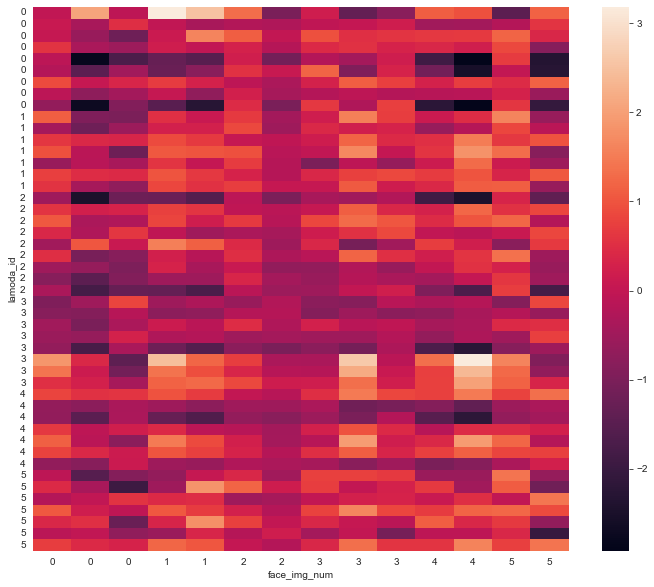

In [96]:
plt.figure(figsize=(12, 10))

pivot = result.pivot(index='lamoda_id', columns='face_img_num', values='score')

lamoda_id_to_man = {row['lamoda_id']: row['man_id'] for _, row in meta.iterrows()}
face_img_to_man = {row['face_img']: row['man_id'] for _, row in meta.iterrows()}
pivot = pivot.sort_index(key=lambda x: [lamoda_id_to_man[y] for y in x])

sns.heatmap(pivot)

plt.gca().set_yticklabels([lamoda_id_to_man[x] for x in pivot.index])
plt.gca().set_xticklabels([face_img_to_man['{}.png'.format(x)] for x in pivot.columns])

plt.show()

In [97]:
from itertools import chain

labels = list(chain.from_iterable([
    [
        {
            'lamoda_id': y,
            'face_img': '{}.png'.format(x),
            'label': lamoda_id_to_man[y] == face_img_to_man['{}.png'.format(x)],
            # 'score': pivot.at[y, x]
        } for y in pivot.index
    ] for x in pivot.columns
]))

labels = pd.DataFrame(labels)

labels.head(10)

,lamoda_id,face_img,label
0,RTLAAZ128901,1.png,True
1,MP002XM09L02,1.png,True
2,RTLAAY403301,1.png,True
3,RTLAAY401501,1.png,True
4,MP002XM1HZ2P,1.png,True
5,RTLAAY401301,1.png,True
6,RTLAAV826701,1.png,True
7,RTLAAV407401,1.png,True
8,RTLAAL116001,1.png,True
9,CA939EMMDKZ5,1.png,False


In [98]:
np.unique(labels.label, return_counts=True)

(array([False,  True]), array([547, 111]))

In [76]:
samples = []

for i in tqdm.tqdm(range(10000)):
    target = np.concatenate([
        np.zeros(547),
        np.ones(111),
    ]).astype(int)

    preds = sps.uniform().rvs(658)

    samples.append(metrics.roc_auc_score(target, preds))
    
    
samples = np.array(samples)
print(np.mean(samples < 0.404))


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 516.66it/s]

0.001


In [99]:
with_labels = result.merge(labels, on=['lamoda_id', 'face_img'])
with_labels.head()

,lamoda_id,face_img,score,original_man,tested_man,face_img_num,label
0,MP002XM09L02,1.png,0.098668,0,0,1,True
1,MP002XM09L02,10.png,0.183460,0,3,10,False
2,MP002XM09L02,11.png,-0.486438,0,4,11,False
3,MP002XM09L02,12.png,-0.446222,0,4,12,False
4,MP002XM09L02,13.png,-0.225388,0,5,13,False


In [100]:
with_labels['ranks'] = with_labels.groupby('lamoda_id')['score'].rank(method='first')

In [101]:
metrics.roc_auc_score(with_labels.label.astype(int), with_labels.score)

0.4748093614638405

In [102]:
metrics.roc_auc_score(with_labels.label.astype(int), with_labels.ranks)

0.48180904853665363

In [103]:
for man in range(6):
    curr = with_labels[with_labels.tested_man == man]
    print(metrics.roc_auc_score(curr.label.astype(int), curr.ranks))

0.5380116959064327
0.6611607142857143
0.5040204678362573
0.39814814814814814
0.39642857142857135
0.5026785714285714


In [169]:
trues = with_labels[with_labels.label == True].groupby('face_img_num').mean().reset_index()[
    ['face_img_num', 'ranks']
].rename(columns={'ranks': 'mean_on_trues'})

falses = with_labels[with_labels.label == False].groupby('face_img_num').mean().reset_index()[
    ['face_img_num', 'ranks']
].rename(columns={'ranks': 'mean_on_falses'})

an = trues.merge(falses, on='face_img_num')
an['diff'] = an['mean_on_trues'] - an['mean_on_falses']
an

,face_img_num,mean_on_trues,mean_on_falses,diff
0,1,11.555556,11.289474,0.266082
1,2,7.111111,6.289474,0.821637
2,3,5.888889,3.578947,2.309942
3,4,6.857143,8.250000,-1.392857
4,5,6.142857,8.750000,-2.607143
5,6,7.111111,6.605263,0.505848
6,7,7.555556,6.052632,1.502924
7,8,6.500000,4.615385,1.884615
8,9,5.375000,5.230769,0.144231
9,10,3.750000,4.051282,-0.301282


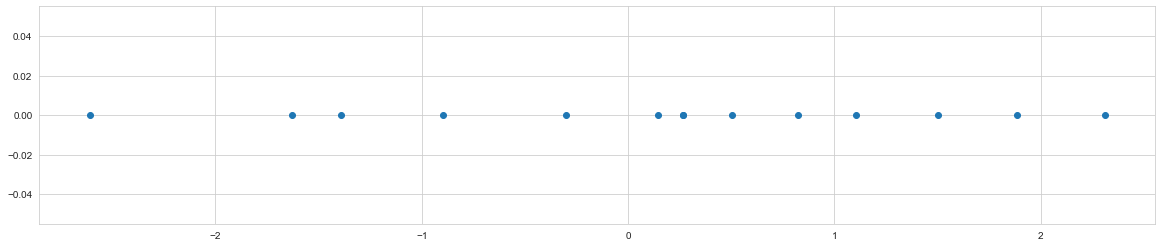

In [179]:
plt.figure(figsize=(20, 4))

plt.scatter(
    np.array(an['diff']),
    np.zeros_like(np.array(an['diff'])),
)
plt.show()

In [170]:
clean = with_labels[
    (with_labels.face_img_num != 4) & (with_labels.face_img_num != 5)
]

In [171]:
metrics.roc_auc_score(clean.label.astype(int), clean.ranks)

0.5291066027947637

In [13]:
metrics.roc_auc_score(with_labels.label.astype(int), with_labels.ranks)

0.4044007444373075

In [14]:
trues = np.array(with_labels[with_labels.label == True].score)
falses = np.array(with_labels[with_labels.label == False].score)


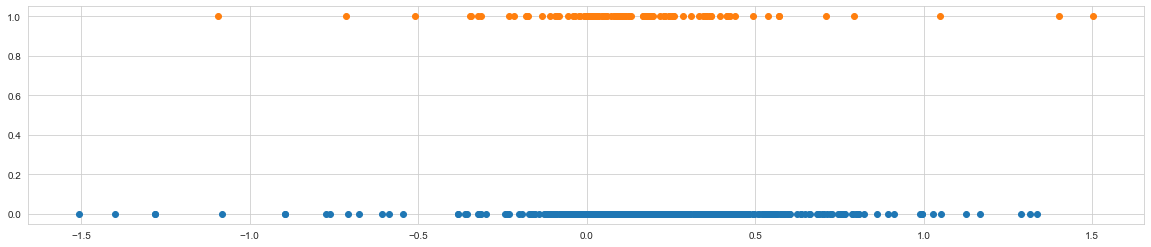

In [15]:
plt.figure(figsize=(20, 4))

plt.scatter(
    x=falses,
    y=np.zeros_like(falses)
)

plt.scatter(
    x=trues,
    y=np.ones_like(trues)
)

plt.show()

In [16]:
with_labels.head()

,lamoda_id,face_img,score,original_man,tested_man,face_img_num,label,ranks
0,MP002XM09L02,1.png,0.125012,0,0,1,True,6.0
1,MP002XM09L02,10.png,0.006406,0,3,10,False,3.0
2,MP002XM09L02,11.png,0.189189,0,4,11,False,11.0
3,MP002XM09L02,12.png,0.463499,0,4,12,False,14.0
4,MP002XM09L02,13.png,0.216824,0,5,13,False,12.0


In [194]:
bad = [
    'MP002XM1RHAT',
    'MP002XM09L02',
    'MP002XU04894',
    'MP002XU04TBW',
    'MP002XW0AL4G',
    'MP002XW0B980',
    'RTLAAL018401',
    'RTLAAL718701',
    'RTLAAV826701',
    'RTLAAY098601',
    'RTLAAY760801',
    'RTLABA230001',
    'RTLABB484601',
    'RTLABA388501',
]

good_index = [x not in bad for x in with_labels.lamoda_id]

In [195]:
good_only = with_labels.loc[good_index]

In [196]:
metrics.roc_auc_score(good_only.label.astype(int), good_only.score)

0.5101161858974359